In [3]:
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import os
import matplotlib.pyplot as plt
import scipy.sparse 
import sklearn

from utils import *

%matplotlib inline
data_path = 'D:/Fall 2018/proj_5/'
seed=1204

In [4]:
sales    = pd.read_csv(os.path.join(data_path, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(data_path, 'items.csv'))
item_categories = pd.read_csv(os.path.join(data_path, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(data_path, 'shops.csv'))
test            = pd.read_csv(os.path.join(data_path, 'test.csv.gz'))

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


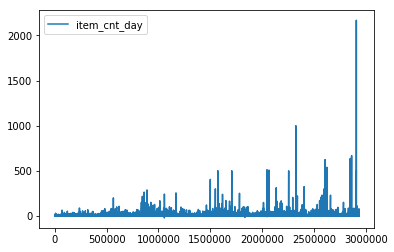

In [10]:
sales[['item_cnt_day']].plot()


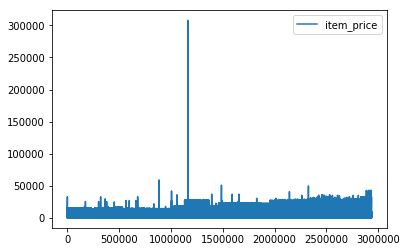

In [11]:
sales[['item_price']].plot()

In [12]:
sales = sales[sales['item_cnt_day']<=1000]
sales = sales[sales['item_price']<100000]

In [13]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates to get rid of duplicates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [14]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [15]:
gb.head()

,shop_id,item_id,date_block_num,item_cnt_day
,,,,target
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0


In [16]:
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
gb.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target'], dtype='object')

In [17]:
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

In [18]:
all_data.head()

,shop_id,item_id,date_block_num,target
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


In [19]:
all_data =pd.merge(all_data,items,on=['item_id'],how='left')

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


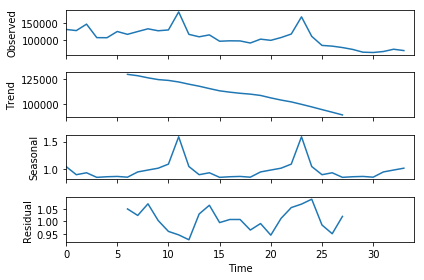

In [20]:
import statsmodels.api as sm
pattern=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
pattern.astype('float')
res = sm.tsa.seasonal_decompose(pattern.values,freq=12,model = 'multiplicative')
#plt.figure(figsize=(16,12))
fig = res.plot()

In [21]:
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'shop_block_target_sum':'sum','shop_block_target_mean':np.mean}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [22]:
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'item_block_target_sum':'sum','item_block_target_mean':np.mean}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [23]:
sales =pd.merge(sales,items,on=['item_id'],how='left')
gb = sales.groupby(['item_category_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'item_cat_block_target_sum':'sum','item_cat_block_target_mean':np.mean}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [24]:
def downcast_dtypes(df):
	'''
	Changes column types in the dataframe: 
		
		`float64` type to `float32`
		`int64`   type to `int32`
	'''

	# Select columns to downcast
	float_cols = [c for c in df if df[c].dtype == "float64"]
	int_cols =   [c for c in df if df[c].dtype == "int64"]

	# Downcast
	df[float_cols] = df[float_cols].astype(np.float32)
	df[int_cols]   = df[int_cols].astype(np.int32)

	return df

all_data = downcast_dtypes(all_data)

In [25]:
all_data.shape

(10913804, 12)

In [26]:
all_data.head()

,shop_id,item_id,date_block_num,target,item_name,item_category_id,shop_block_target_sum,shop_block_target_mean,item_block_target_sum,item_block_target_mean,item_cat_block_target_sum,item_cat_block_target_mean
0,59,22154,0,1.0,ЯВЛЕНИЕ 2012 (BD),37,2017.0,1.092041,18.0,1.0,6094.0,1.053414
1,59,2552,0,0.0,DEEP PURPLE The House Of Blue Light LP,58,2017.0,1.092041,0.0,0.0,287.0,0.969595
2,59,2554,0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,2017.0,1.092041,1.0,1.0,287.0,0.969595
3,59,2555,0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2017.0,1.092041,2.0,1.0,268.0,1.007519
4,59,2564,0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,2017.0,1.092041,5.0,1.0,701.0,0.990113


In [62]:
all_data.to_csv(data_path+'new_sales.csv',index=False)

In [27]:
index_cols = ['shop_id', 'item_id', 'date_block_num','item_category_id']
cols_to_rename = list(all_data.columns.difference(index_cols))
for i in ['item_name']:
    cols_to_rename.remove(i)
cols_gb_item = [i for i in cols_to_rename if 'item_block' in i]
cols_gb_shop = [i for i in cols_to_rename if 'shop_block' in i]
cols_gb_cat = [i for i in cols_to_rename if 'item_cat' in i]
cols_gb_all = ['target']
cols_gb_key=[['item_id'],['shop_id'],['item_category_id'],['shop_id','item_id']]
cols_gb_value = [cols_gb_item,cols_gb_shop,cols_gb_cat,cols_gb_all]
cols_gb_value

[['item_block_target_mean', 'item_block_target_sum'],
 ['shop_block_target_mean', 'shop_block_target_sum'],
 ['item_cat_block_target_mean', 'item_cat_block_target_sum'],
 ['target']]

In [28]:
shift_range = [1,2,3,5,12]
for month_shift in shift_range:
    for k,v in zip(cols_gb_key,cols_gb_value): 
        index_col = ['date_block_num'] + k
        train_shift = all_data[index_col + v].copy().drop_duplicates()

        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in v else x
        train_shift = train_shift.rename(columns=foo)
        all_data = pd.merge(all_data, train_shift, on=index_col, how='left').fillna(0)

In [29]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'item_name',
       'item_category_id', 'shop_block_target_sum', 'shop_block_target_mean',
       'item_block_target_sum', 'item_block_target_mean',
       'item_cat_block_target_sum', 'item_cat_block_target_mean',
       'item_block_target_mean_lag_1', 'item_block_target_sum_lag_1',
       'shop_block_target_mean_lag_1', 'shop_block_target_sum_lag_1',
       'item_cat_block_target_mean_lag_1', 'item_cat_block_target_sum_lag_1',
       'target_lag_1', 'item_block_target_mean_lag_2',
       'item_block_target_sum_lag_2', 'shop_block_target_mean_lag_2',
       'shop_block_target_sum_lag_2', 'item_cat_block_target_mean_lag_2',
       'item_cat_block_target_sum_lag_2', 'target_lag_2',
       'item_block_target_mean_lag_3', 'item_block_target_sum_lag_3',
       'shop_block_target_mean_lag_3', 'shop_block_target_sum_lag_3',
       'item_cat_block_target_mean_lag_3', 'item_cat_block_target_sum_lag_3',
       'target_lag_3', 'item_block_

In [30]:
all_data.to_pickle(data_path+'new_sales_lag_after12.pickle')

In [31]:
all_data = pd.read_pickle(data_path+'new_sales_lag_after12.pickle')

In [72]:

from utils import *

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import lightgbm as lgb

%matplotlib inline
data_path = 'data/'
seed=1204

submission_path=data_path+'submission/'
fold_path = 'fold_data/'


cv_loss_list=[]
n_iteration_list=[]
def score(params):
    print("Training with params: ")
    print(params)
    cv_losses=[]
    cv_iteration=[]
    for (train_idx,val_idx) in cv:
        cv_train = X.iloc[train_idx]
        cv_val = X.iloc[val_idx]
        cv_y_train = y[train_idx]
        cv_y_val = y[val_idx]
        lgb_model = lgb.train(params, lgb.Dataset(cv_train, label=cv_y_train), 2000, 
                          lgb.Dataset(cv_val, label=cv_y_val), verbose_eval=False, 
                          early_stopping_rounds=100)
       
        train_pred = lgb_model.predict(cv_train,lgb_model.best_iteration+1)
        val_pred = lgb_model.predict(cv_val,lgb_model.best_iteration+1)
        
        val_loss = root_mean_squared_error(cv_y_val,val_pred)
        train_loss = root_mean_squared_error(cv_y_train,train_pred)
        print('Train RMSE: {}. Val RMSE: {}'.format(train_loss,val_loss))
        print('Best iteration: {}'.format(lgb_model.best_iteration))
        cv_losses.append(val_loss)
        cv_iteration.append(lgb_model.best_iteration)
    print('6 fold results: {}'.format(cv_losses))
    cv_loss_list.append(cv_losses)
    n_iteration_list.append(cv_iteration)
    
    mean_cv_loss = np.mean(cv_losses)
    print('Average iterations: {}'.format(np.mean(cv_iteration)))
    print("Mean Cross Validation RMSE: {}\n".format(mean_cv_loss))
    return {'loss': mean_cv_loss, 'status': STATUS_OK}

def optimize(space,seed=seed,max_evals=5):
    
    best = fmin(score, space, algo=tpe.suggest, 
        # trials=trials, 
        max_evals=max_evals)
    return best

In [32]:
def get_X_y(df,end,clip=20):
    # don't drop date_block_num
    df = df.loc[df.date_block_num <= end]
    cols_to_drop=['target','item_name'] + df.columns.values[6:12].tolist()
    y = np.clip(df.target.values,0,clip)
    X = df.drop(cols_to_drop,axis=1)
    return X,y



def get_cv_idxs(df,start,end):
	result=[]
	for i in range(start,end+1):
		dates = df.date_block_num
		train_idx = np.array(df.loc[dates <i].index)
		val_idx = np.array(df.loc[dates == i].index)
		result.append((train_idx,val_idx))
	return np.array(result)


X,y = get_X_y(all_data,33)
X.drop('date_block_num',axis=1,inplace=True)
cv = get_cv_idxs(all_data,28,33)

In [77]:
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import os
import matplotlib.pyplot as plt
import scipy.sparse 

from sklearn.metrics import mean_squared_error,make_scorer
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import lightgbm as lgb
import xgboost as xgb



def get_submission(item_cnt_month,sub_name,clip=20,data_path ='data/' ):
	item_cnt_month = np.clip(item_cnt_month,0,clip)
	test= pd.read_csv(os.path.join(data_path, 'test.csv.gz'))
	sub = test.copy()
	sub['item_cnt_month'] = item_cnt_month
	sub.drop(['item_id','shop_id'],axis=1,inplace=True)
	sub.to_csv(data_path+'submission/' + sub_name+'.csv',index=False)
	return sub


def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    return df

def get_cv_idxs(df,start,end):
    result=[]
    for i in range(start,end+1):
        dates = df.date_block_num
        train_idx = np.array(df.loc[dates <i].index)
        val_idx = np.array(df.loc[dates == i].index)
        result.append((train_idx,val_idx))
    return np.array(result)

def get_X_y(df,end,clip=20):
    df = df.loc[df.date_block_num <= end]
    cols_to_drop=['target','item_name'] + df.columns.values[6:12].tolist()
    y = np.clip(df.target.values,0,clip)
    X = df.drop(cols_to_drop,axis=1)
    return X,y

def root_mean_squared_error(truth,pred):
    return sqrt(mean_squared_error(truth,pred))

    
def get_train_val(X,y,val_block):
    if val_block>33:
        raise ValueError('Maximum date_block_n is 33')
    X_train  = X[X.date_block_num<val_block].copy()
    X_val = X[X.date_block_num==val_block].copy()
    y_train = y[X_train.index.tolist()].copy()
    y_val = y[X_val.index.tolist()].copy()
    X_train.drop('date_block_num',axis=1,inplace=True)
    X_val.drop('date_block_num',axis=1,inplace=True)
    return X_train,X_val,y_train,y_val

def timeseries_cv(clf_name,X,y,params,cv,loss_metric,early_stopping_round=100,get_oof=False,extra_rounds=1):
    '''
    Doing XGBoost and LightGBM CV for time series.
    clf_name: 'xgb' or 'lgb'
    cv: [(train idx time 1,val idx time 1),( train idx time 2, val idx time 2), ...]
    '''
    print("Training with params: ")
    print(params)

    oof_train = np.zeros([0,])
    cv_losses=[]
    cv_iteration=[]

    for (train_idx,val_idx) in cv:
        cv_train = X.iloc[train_idx]
        cv_val = X.iloc[val_idx]
        cv_y_train = y[train_idx]
        cv_y_val = y[val_idx]

        train_pred=None
        val_pred=None
        best_nround=0
        if clf_name == 'lgb':

            lgb_model = lgb.train(params, lgb.Dataset(cv_train, label=cv_y_train), 2000, 
                      lgb.Dataset(cv_val, label=cv_y_val), verbose_eval=False, 
                      early_stopping_rounds=early_stopping_round)
            best_nround=lgb_model.best_iteration
            train_pred = lgb_model.predict(cv_train,best_nround)
            val_pred = lgb_model.predict(cv_val,best_nround+extra_rounds)


        else:
            return None

        #  oof_train[dbn_level2==current_bn] = val_pred
        if get_oof:
            oof_train = np.append(oof_train,val_pred)

        val_loss = loss_metric(cv_y_val,val_pred)
        train_loss = loss_metric(cv_y_train,train_pred)
        print('Train RMSE: {}. Val RMSE: {}'.format(train_loss,val_loss))
        print('Best iteration: {}'.format(best_nround))
        cv_losses.append(val_loss)
        cv_iteration.append(best_nround)

    print('n validation fold results: {}'.format(cv_losses))

    print('Average iterations: {}'.format(int(np.mean(cv_iteration))))
    print("Mean Cross Validation RMSE: {}\n".format(np.mean(cv_losses)))

    return (oof_train,cv_losses) if get_oof else cv_losses



In [78]:
# from tqdm import tqdm
# space = {
# #     'max_depth': hp.choice('max_depth', np.arange(3, 15, dtype=int)),
#     'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
#     'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#     'min_data_in_leaf': hp.choice('min_data_in_leaf',np.arange(5, 30,1, dtype=int)),
#     'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
#     'seed':seed,
#     'objective': 'regression',
#     'metric':'rmse',
# }
# best_hyperparams = tqdm(optimize(space,max_evals=10))
# print("The best hyperparameters are: ")
# print(best_hyperparams)

Training with params: 
{'colsample_bytree': 0.8, 'learning_rate': 0.30000000000000004, 'metric': 'rmse', 'min_data_in_leaf': 23, 'objective': 'regression', 'seed': 1204, 'subsample': 0.55}
Train RMSE: 0.9429326973707985. Val RMSE: 0.8654626488337239
Best iteration: 8
Train RMSE: 0.901660360336843. Val RMSE: 0.7772653841080625
Best iteration: 27


KeyboardInterrupt: 

In [33]:
lgb_params = {
               'colsample_bytree': 0.75,
               'metric': 'rmse',
               'min_data_in_leaf': 128, 
               'subsample': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'regression', 
               'bagging_seed': 128, 
               'num_leaves': 128,
               'bagging_freq':1,
               'seed':1204
              }

In [34]:
X,y = get_X_y(all_data,33)
X.drop('date_block_num',axis=1,inplace=True)
cv = get_cv_idxs(all_data,28,33)

In [36]:
import lightgbm as lgb
lgb_model_full = lgb.train(lgb_params, lgb.Dataset(X, label=y), 700, 
                      lgb.Dataset(X, label=y), verbose_eval=10)

[10]	valid_0's rmse: 1.10654
[20]	valid_0's rmse: 1.0285
[30]	valid_0's rmse: 0.978317
[40]	valid_0's rmse: 0.946587
[50]	valid_0's rmse: 0.923653
[60]	valid_0's rmse: 0.908451
[70]	valid_0's rmse: 0.897032
[80]	valid_0's rmse: 0.888885
[90]	valid_0's rmse: 0.881692
[100]	valid_0's rmse: 0.8762
[110]	valid_0's rmse: 0.871205
[120]	valid_0's rmse: 0.867047
[130]	valid_0's rmse: 0.863301
[140]	valid_0's rmse: 0.859844
[150]	valid_0's rmse: 0.856823
[160]	valid_0's rmse: 0.854367
[170]	valid_0's rmse: 0.851952
[180]	valid_0's rmse: 0.849648
[190]	valid_0's rmse: 0.847222
[200]	valid_0's rmse: 0.845314
[210]	valid_0's rmse: 0.84364
[220]	valid_0's rmse: 0.842048
[230]	valid_0's rmse: 0.840437
[240]	valid_0's rmse: 0.838802
[250]	valid_0's rmse: 0.8373
[260]	valid_0's rmse: 0.835856
[270]	valid_0's rmse: 0.834413
[280]	valid_0's rmse: 0.833172
[290]	valid_0's rmse: 0.831988
[300]	valid_0's rmse: 0.830876
[310]	valid_0's rmse: 0.829829
[320]	valid_0's rmse: 0.828883
[330]	valid_0's rmse: 0.8

In [43]:
test = pd.read_csv(os.path.join(data_path, 'test.csv'))

In [44]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [45]:
test.drop(['ID'],axis=1,inplace=True)

In [46]:
test_pred = lgb_model_full.predict(test,100)
#get_submission(test_pred,'coursera_tuned_lightgbm_basic_6folds');

In [47]:
test_pred

array([0.62059748, 0.57235332, 0.58268462, ..., 0.57760579, 0.57225337,
       0.6477477 ])

In [50]:
test_p = pd.DataFrame(test_pred,columns = ['item_cnt_month'])
test_p.to_csv(data_path+'predictions.csv')

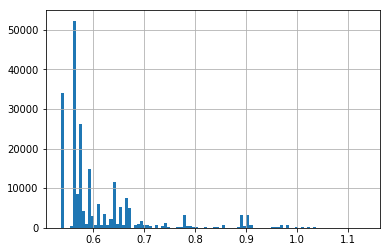

In [99]:
pd.Series(test_pred).hist(bins=100)

In [100]:
oof_train,_ = timeseries_cv('lgb',X,y,lgb_params,cv,root_mean_squared_error,150,True)

Training with params: 
{'colsample_bytree': 0.75, 'metric': 'rmse', 'min_data_in_leaf': 128, 'subsample': 0.75, 'learning_rate': 0.03, 'objective': 'regression', 'bagging_seed': 128, 'num_leaves': 128, 'bagging_freq': 1, 'seed': 1204, 'verbose': 1}
Train RMSE: 0.8992746186362752. Val RMSE: 0.8462488737858715
Best iteration: 79
Train RMSE: 0.7988426427793881. Val RMSE: 0.7647061135095428
Best iteration: 804
Train RMSE: 0.77839635953657. Val RMSE: 0.7000536824489353
Best iteration: 1258
Train RMSE: 0.7629590751168324. Val RMSE: 0.7650474843013579
Best iteration: 1708
Train RMSE: 0.7564403486698138. Val RMSE: 0.8606166342203315
Best iteration: 1936
Train RMSE: 0.848735926947895. Val RMSE: 0.9065580154816443
Best iteration: 179
n validation fold results: [0.8462488737858715, 0.7647061135095428, 0.7000536824489353, 0.7650474843013579, 0.8606166342203315, 0.9065580154816443]
Average iterations: 994
Mean Cross Validation RMSE: 0.8072051339579471



In [102]:
oof_df = pd.Series(oof_train)
oof_df.to_pickle(data_path+'lgb_best.pickle')